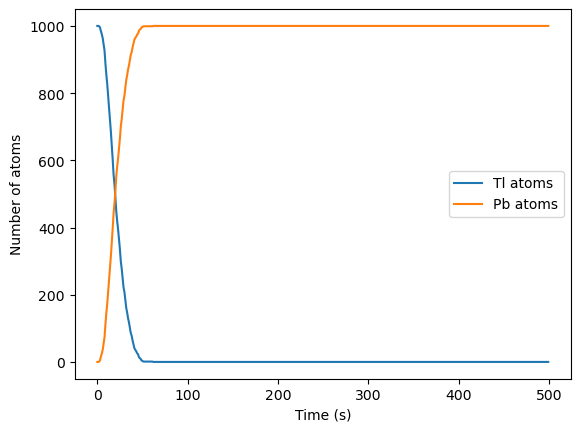

In [1]:
#1
import matplotlib.pyplot as plt
import numpy as np

initial_Tl_atoms = 1000
initial_Pb_atoms = 0
half_life = 3.052 * 60  # in seconds

def decay_simulation():
    time_steps = np.arange(0, 500, 1)  
    Tl_atoms = [initial_Tl_atoms]
    Pb_atoms = [initial_Pb_atoms]

    for t in time_steps:
        decay_prob = 1 - 2**(-t/half_life)
        decayed_Tl = np.random.binomial(Tl_atoms[-1], decay_prob)
        Tl_atoms.append(Tl_atoms[-1] - decayed_Tl)
        Pb_atoms.append(Pb_atoms[-1] + decayed_Tl)

    plt.plot(time_steps, Tl_atoms[:-1], label='Tl atoms')
    plt.plot(time_steps, Pb_atoms[:-1], label='Pb atoms')
    plt.xlabel('Time (s)')
    plt.ylabel('Number of atoms')
    plt.legend()
    plt.show()

decay_simulation()


In [2]:
#2
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return np.sin(1/(1-x))**2

# Hit/Miss method
def hit_miss_integration(N):
    x = np.random.uniform(0, 2, N)
    y = np.random.uniform(0, 1, N)

    integral_estimate = 2 * np.mean(y < f(x))
    error = 2 * np.std(y < f(x)) / np.sqrt(N)

    return integral_estimate, error

N = 10000
estimate, error = hit_miss_integration(N)
print(f"Hit/Miss Method: Estimate = {estimate}, Error = {error}")
# Mean Value method
def mean_value_integration(N):
    x = np.random.uniform(0, 2, N)
    integral_estimate = 2 * np.mean(f(x))

    error = 2 * np.std(f(x)) / np.sqrt(N)

    return integral_estimate, error

# Call the function
estimate, error = mean_value_integration(N)
print(f"Mean Value Method: Estimate = {estimate}, Error = {error}")


Hit/Miss Method: Estimate = 1.3496, Error = 0.009368990553949767


In [5]:
#4
import numpy as np

def f(x):
    return x**(-1/2) / (np.exp(x) + 1)

def w(x):
    return 1 / np.sqrt(x)

# Monte Carlo integration with importance sampling
def importance_sampling_integration(N):
    x = np.random.uniform(0, 1, N)
    integral_estimate = np.mean(f(x) / w(x))

    return integral_estimate

N = 100000
integral_estimate = importance_sampling_integration(N)
print(f"Importance Sampling Method: Estimate = {integral_estimate}")


Importance Sampling Method: Estimate = 0.37966686149420326


In [ ]:
#3
N = 100000
points = np.random.rand(N, 2)
inside_circle = points[:, 0]**2 + points[:, 1]**2 <= 1

area_estimate = np.mean(inside_circle)
print(f"Estimated Area of Unit Circle in 2D: {area_estimate}")

# Generalization for 10D sphere
N = 100000
points = np.random.rand(N, 10)
inside_sphere = np.sum(points**2, axis=1) <= 1

volume_estimate = np.mean(inside_sphere)
print(f"Estimated Volume of 10D Unit Sphere: {volume_estimate}")
